In [1]:
# based on https://github.com/allanzelener/YAD2K
    

In [2]:
#! /usr/bin/env python
"""Run a YOLO_v2 style detection model on test images."""
import argparse
import colorsys
import imghdr
import os
import random
from matplotlib.pyplot import imshow, show
import numpy as np
from keras import backend as K
from keras.models import load_model
from PIL import Image, ImageDraw, ImageFont
from yad2k.yad2k.models.keras_yolo import yolo_eval, yolo_head

% matplotlib inline

Using TensorFlow backend.


In [3]:
this_dir = os.getcwd()
model_path = os.path.join(this_dir, "data/Yolo/yolo.h5")
anchors_path = os.path.join(this_dir, "data/Yolo//yolo_anchors.txt")
classes_path = os.path.join(this_dir, "data/Yolo/coco_classes.txt")
test_path = os.path.join(this_dir, "data/images")
output_path = os.path.join(this_dir, "data/images_out/yolo")

In [4]:
with open(classes_path) as f:
    class_names = f.readlines()
class_names = [c.strip() for c in class_names]

with open(anchors_path) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)

/opt/conda/lib/python3.6/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
100%|██████████| 100/100 [03:02<00:00,  1.83s/it]


[1.8878421783447266, 1.804835319519043, 1.7824029922485352, 1.8072140216827393, 1.7874565124511719, 1.8081283569335938, 1.819500207901001, 1.8068280220031738, 1.7882797718048096, 1.8259308338165283, 1.799684762954712, 1.8138270378112793, 1.8189804553985596, 1.8245189189910889, 1.8727176189422607, 1.79427170753479, 1.8028242588043213, 1.8059706687927246, 1.8064563274383545, 1.808626413345337, 1.8173861503601074, 1.8252794742584229, 1.8468825817108154, 1.830930471420288, 1.825223684310913, 1.8199028968811035, 1.8067553043365479, 1.7968745231628418, 1.8277771472930908, 1.8186542987823486, 1.8149807453155518, 1.770892858505249, 1.7887520790100098, 1.8443324565887451, 1.8664300441741943, 1.8518524169921875, 1.864076852798462, 1.8426151275634766, 1.841923713684082, 1.8480374813079834, 1.8737928867340088, 1.8648478984832764, 1.865694522857666, 1.844832181930542, 1.875131368637085, 1.8210737705230713, 1.8106911182403564, 1.825308084487915, 1.818572759628296, 1.815629482269287, 1.79527139663696

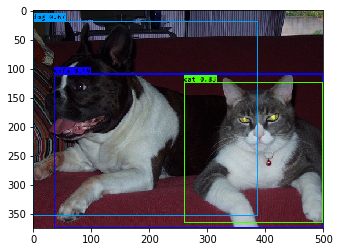

Found 6 boxes for 004545.jpg
bench 0.40 (459, 150) (499, 182)
dog 0.50 (142, 206) (202, 344)
person 0.69 (432, 121) (454, 176)
truck 0.73 (8, 100) (136, 197)
person 0.85 (276, 0) (351, 246)
horse 0.86 (220, 80) (426, 340)


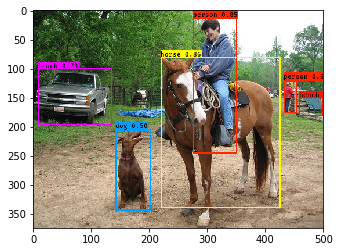

Found 1 boxes for 000542.jpg
cat 0.70 (29, 33) (500, 368)


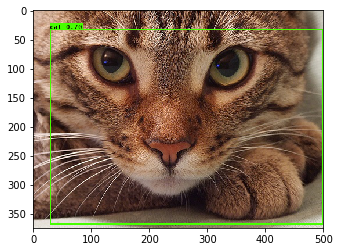

Found 2 boxes for 001150.jpg
dog 0.60 (163, 65) (438, 375)
person 0.61 (14, 0) (207, 185)


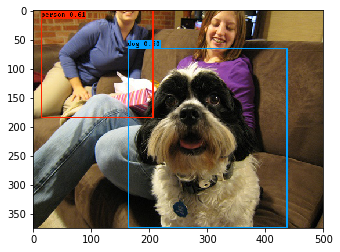

Found 2 boxes for 000456.jpg
person 0.54 (125, 121) (179, 162)
bus 0.76 (87, 41) (416, 300)


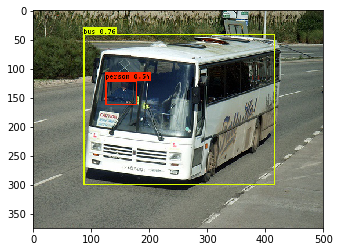

In [5]:
if not os.path.exists(output_path):
    print('Creating output path {}'.format(output_path))
    os.mkdir(output_path)

sess = K.get_session()
yolo_model = load_model(model_path)


# Check if model is fully convolutional, assuming channel last order.
model_image_size = yolo_model.layers[0].input_shape[1:3]
is_fixed_size = model_image_size != (None, None)

# Generate colors for drawing bounding boxes.
hsv_tuples = [(x / len(class_names), 1., 1.)
              for x in range(len(class_names))]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(
    map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
        colors))
random.seed(10101)  # Fixed seed for consistent colors across runs.
random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
random.seed(None)  # Reset seed to default.

# Generate output tensor targets for filtered bounding boxes.
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(
    yolo_outputs,
    input_image_shape,
    score_threshold=.3,
    iou_threshold=.5)


# Performance measurements block
import time
from tqdm import tqdm
perf_image = this_dir + "/data/images/" + "000542.jpg"
times = list()
image = Image.open(perf_image)
if is_fixed_size:  # TODO: When resizing we can use minibatch input.
    resized_image = image.resize(
        tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
else:
    # Due to skip connection + max pooling in YOLO_v2, inputs must have
    # width and height as multiples of 32.
    new_image_size = (image.width - (image.width % 32),
                      image.height - (image.height % 32))
    resized_image = image.resize(new_image_size, Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    print(image_data.shape)

image_data /= 255.
image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

for i in tqdm(range(100)):
    timestart = time.time()
    sess.run(
        [boxes, scores, classes],
        feed_dict={
            yolo_model.input: image_data,
            input_image_shape: [image.size[1], image.size[0]],
            K.learning_phase(): 0
        })
    times.append(time.time() - timestart)
print(times)
performance = np.array(times)
print("Mean:", np.mean(performance))
print("Median:", np.median(performance))
print("Q25:", np.percentile(performance, 25))
print("Q75:", np.percentile(performance, 75))
##############################################################

for image_file in os.listdir(test_path):
    try:
        image_type = imghdr.what(os.path.join(test_path, image_file))
        if not image_type:
            continue
    except IsADirectoryError:
        continue

    image = Image.open(os.path.join(test_path, image_file))
    if is_fixed_size:  # TODO: When resizing we can use minibatch input.
        resized_image = image.resize(
            tuple(reversed(model_image_size)), Image.BICUBIC)
        image_data = np.array(resized_image, dtype='float32')
    else:
        # Due to skip connection + max pooling in YOLO_v2, inputs must have
        # width and height as multiples of 32.
        new_image_size = (image.width - (image.width % 32),
                          image.height - (image.height % 32))
        resized_image = image.resize(new_image_size, Image.BICUBIC)
        image_data = np.array(resized_image, dtype='float32')
        print(image_data.shape)

    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

    out_boxes, out_scores, out_classes = sess.run(
        [boxes, scores, classes],
        feed_dict={
            yolo_model.input: image_data,
            input_image_shape: [image.size[1], image.size[0]],
            K.learning_phase(): 0
        })
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))

    font = ImageFont.truetype(
        font='yad2k/font/FiraMono-Medium.otf',
        size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw
    imshow(np.asarray(image))
    show()
    image.save(os.path.join(output_path, image_file), quality=90)
sess.close()

In [6]:
performance = np.array(times)
print("Mean:", np.mean(performance))
print("Median:", np.median(performance))
print("Q25:", np.percentile(performance, 25))
print("Q75:", np.percentile(performance, 75))

Mean: 1.82680552721
Median: 1.82095134258
Q25: 1.80970609188
Q75: 1.84191298485
